#Sociology of the Digital Public Space - Group Research

In [ ]:
# author: Anthammax https://github.com/anthammax
# date: 29/11/2023
# last_update : 29/11/2023, 12:00:00

# Import

## Libraries and dataset

In [1]:
%%capture
!pip install contractions

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import json
import seaborn as sns
import nltk
import contractions
import inflect
import re, string, unicodedata

from datetime import datetime, timedelta, date
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.corpus import stopwords
from nltk.util import ngrams

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Functions

In [109]:
# Functions ----> Dataviz

def position(df):

  po1 = list(df.index).index('2022-10-27')
  po2 = list(df.index).index('2022-11-18')
  po3 = list(df.index).index('2022-12-12')
  po4 = list(df.index).index('2023-04-17')
  po5 = list(df.index).index('2023-07-12')

  return po1, po2, po3, po4, po5

def convert_date_time(starting_date:str):
  """Check if the date format is ok and convert the date into datetime format"""
  return int(time.mktime(datetime.strptime(starting_date, "%Y-%m-%d").timetuple())) #by the default the time is YYYY-MM-DD-00:00

def convert_date_time2(starting_date:str):
  """Check if the date format is ok and convert the date into datetime format"""
  return int(time.mktime(datetime.strptime(starting_date, "%Y-%m").timetuple())) #by the default the time is YYYY-MM-DD-00:00

def boxplot_hash(targeted_hashtags:list, data, dates:list):
  dict_tweets_month = {}
  for hash in targeted_hashtags:
    dict_tweets_month[hash] = [0 for i in range(len(dates))]

  for i in data.index:
    all_hashtags = list(data['hashtags'])[i]

    for hash in targeted_hashtags:

      if hash[1:] in all_hashtags:
        date_position = dates.index(df['local_time'][i][:7])
        dict_tweets_month[hash][date_position] += 1

  df_hash = pd.DataFrame(dict_tweets_month, index=dates)
  return df_hash

def most_active_user(df):
  """Return from an original dataset of tweets all users and the number of tweets they have published"""
  all_users = list(df['user_screen_name'].unique())
  top_user = { 'total': []}
  index = []

  for user in all_users:
    index.append(user)
    top_user['total'].append(len(df[df['user_screen_name'] == user]))

  new_df = pd.DataFrame(top_user, index=index).sort_values(by=['total'], ascending=[False])

  return new_df



def boxplot_user(targeted_users:list, data, dates:list):
  dict_tweets_month = {}
  for user in targeted_users:
    dict_tweets_month[user] = [0 for i in range(len(dates))]
    data2 = data[data['user_screen_name'] == user]

    for i in data2.index:
      date_position = dates.index(data2['local_time'][i][:7])
      dict_tweets_month[user][date_position] += 1

  df_top_user = pd.DataFrame(dict_tweets_month, index=dates)
  return df_top_user

def hex_to_RGB(hex_str):
    """ #FFFFFF -> [255,255,255]"""
    #Pass 16 to the integer function for change of base
    return [int(hex_str[i:i+2], 16) for i in range(1,6,2)]

def get_color_gradient(c1, c2, n):
    """
    Given two hex colors, returns a color gradient
    with n colors.
    """
    assert n > 1
    c1_rgb = np.array(hex_to_RGB(c1))/255
    c2_rgb = np.array(hex_to_RGB(c2))/255
    mix_pcts = [x/(n-1) for x in range(n)]
    rgb_colors = [((1-mix)*c1_rgb + (mix*c2_rgb)) for mix in mix_pcts]
    return ["#" + "".join([format(int(round(val*255)), "02x") for val in item]) for item in rgb_colors]


def boxplot_hash(targeted_hashtags:list, df):

  def date(nb):
    return str(datetime.fromtimestamp(nb))

  #per second
  df = dataset[['timestamp_utc', 'hashtags']].copy()
  df['local_time'] = df['timestamp_utc'].apply(date)
  df = df.drop('timestamp_utc', axis=1)
  for hash in targeted_hashtags:
    modif_hash = "\'" + hash[1:] + "\'"
    df[hash] = df['hashtags'].str.contains(modif_hash).map({True: 1, False: 0})
  df_hash_sec = df.groupby('local_time', as_index=False).sum()

  #daily

  df_hash_daily =  df_hash_sec.copy()
  df_hash_daily['date'] = df_hash_sec['local_time'].str.split(pat=" ").str.get(0)
  df_hash_daily =  df_hash_daily.groupby('date', as_index=False).sum()

  #monthly
  df_hash_monthly =  df_hash_sec.copy()
  df_hash_monthly['date'] = df_hash_monthly['local_time'].str.split(pat="-").str.get(0) + pd.Series('-', index=range(len(df_hash_sec))) + df_hash_monthly['local_time'].str.split(pat="-").str.get(1)
  df_hash_monthly = df_hash_monthly.groupby('date', as_index=False).sum()

  return df_hash_sec, df_hash_daily, df_hash_monthly

def active_user_monthly(dataset, top:int):
  """Create the dataset which select, for the top {top} most active users (that's to say those who published
  the most during the entire dataset period), the number of published tweets by month"""

  #dataset by second
  df = dataset[['user_screen_name', 'local_time']].copy()
  targeted_users = list(dataset['user_screen_name'].value_counts().index)[:top]

  for user in targeted_users:
    df[user] = df['user_screen_name'].str.contains(user).map({True: 1, False: 0}) #count the number of tweets corresponding to the targated user
  df_user_sec = df.groupby('local_time', as_index=False).sum() #sum the number of tweets by merging by users

  #dataset by month
  df_user_monthly =  df_user_sec.copy()
  df_user_monthly['date'] = df_user_monthly['local_time'].str.split(pat="-").str.get(0) + pd.Series('-', index=range(len(df_hash_sec))) + df_user_monthly['local_time'].str.split(pat="-").str.get(1)
  df_user_monthly = df_user_monthly.groupby('date', as_index=False).sum()

  return df_user_monthly


def boxplot_user(targeted_hashtags:list, df):

  def date(nb):
      return str(datetime.fromtimestamp(nb))

  df = df_user[['timestamp_utc', 'hashtags', 'retweet_count', 'like_count', 'reply_count']].copy()
  df['local_time'] = df['timestamp_utc'].apply(date)
  df = df.drop('timestamp_utc', axis=1)
  for hash in targeted_hashtags:
      modif_hash = "\'" + hash[1:] + "\'"
      df[hash] = df['hashtags'].str.contains(modif_hash).map({True: 1, False: 0})
  df_user_sec = df.groupby('local_time', as_index=False).sum()

  #daily
  df_user_daily =  df_user_sec.copy()
  df_user_daily['date'] = df_user_sec['local_time'].str.split(pat=" ").str.get(0)
  df_user_daily =  df_user_daily.groupby('date', as_index=False).sum()

  #monthly
  df_user_monthly =  df_user_sec.copy()
  df_user_monthly['date'] = df_user_monthly['local_time'].str.split(pat="-").str.get(0) + pd.Series('-', index=range(len(df_user_sec))) + df_user_monthly['local_time'].str.split(pat="-").str.get(1)
  df_user_monthly = df_user_monthly.groupby('date', as_index=False).sum()

  return df_user_sec, df_user_daily, df_user_monthly

def basic_info(df_user, hashtag_list):

  print('-------- BASIC INFORMATIONS ------------')
  print(f'==> Name: {df_user.user_screen_name.iloc[0]}, aka {df_user.user_name.iloc[0]}')
  print(f'==> Description: {df_user.user_description.iloc[0]}')
  print(f'==> Location: {df_user.user_location.iloc[0]}')
  print('')
  print(f'==> Number of followers: {int(df_user.user_followers.iloc[0])}')
  print(f'==> Number of following: {int(df_user.user_friends.iloc[0])}')
  print('----------------------------------------')

  df_user_sec, df_user_daily, df_user_monthly = boxplot_user(targeted_hashtags=hashtag_list, df=df_user)

  #hash
  col = hashtag_list + ['date']
  df = df_user_monthly[col].set_index('date')
  ax = df.plot.bar(stacked=True, figsize=(10,7))
  plt.title(f"Number of possible antisemitic tweets hashtags per month for {name}")

  #influence by month
  col = ['date', 'retweet_count', 'like_count', 'reply_count']
  df = df_user_monthly[col].set_index('date')
  ax = df.plot.bar(stacked=False, figsize=(10,7))
  plt.title(f"Metrics about {name}'s influence, by month")

  #influence by day
  col = ['date', 'retweet_count', 'like_count', 'reply_count']
  df = df_user_daily[col].set_index('date')
  ax = df.plot(stacked=False, figsize=(10,7))
  plt.title(f"Metrics about {name}'s influence, by day")
  plt.grid()

def tokenizeandstopwords(text):
  #https://www.kaggle.com/code/vpkprasanna/basic-text-cleaning-wordcloud-and-n-gram-analysis

  # strip links
  link_regex = re.compile('((https?):((//)|(\\\\))+([\w\d:#@%/;$()~_?\+-=\\\.&](#!)?)*)', re.DOTALL)
  links = re.findall(link_regex, text)
  for link in links:
    text = text.replace(link[0], ', ')

  text = text.lower()
  tokens = nltk.word_tokenize(text)
  token_words = [w for w in tokens if w.isalpha()] # taken only words (not punctuation)
  meaningful_words = [w for w in token_words if not w in stopwords.words('english')]
  joined_words = ( " ".join(meaningful_words))
  return joined_words



## Regression

def clean_reg(df):

  def date(nb):
      return str(datetime.fromtimestamp(nb))

  df = dataset[['timestamp_utc', 'antisemitic', 'id']].copy()
  df['local_time'] = df['timestamp_utc'].apply(date)
  df = df.drop('timestamp_utc', axis=1)
  df = df.groupby(['local_time', 'antisemitic']).count()
  df = df.rename(columns={"id": "nb_tweet"})
  df = df.reset_index()

  df_daily = df.copy()
  df_daily['date'] = df_daily['local_time'].str.split(pat=" ").str.get(0)
  df_daily = df_daily.groupby(['date', 'antisemitic'], as_index=False).sum()

  df_monthly = df.copy()
  df_monthly['date'] = df_monthly['local_time'].str.split(pat="-").str.get(0) + pd.Series('-', index=range(len(df))) + df_monthly['local_time'].str.split(pat="-").str.get(1)
  df_monthly = df_monthly.groupby(['date', 'antisemitic'], as_index=False).sum()

  return df, df_daily, df_monthly

def to_reg(ds, date:str, n:int):
  df = ds.copy()

  name_date = 'date_' + str(n)
  name_ttt = 'time_to_treat_' + str(n)
  name_post = 'post_' + str(n)

  df[name_date] = date
  df['date_code2'] = convert_date_time2(date)
  df['date_code1'] = df['date'].apply(convert_date_time2)

  df[name_ttt] = (df['date_code1'] - df['date_code2']) //2592000 #2592000 corresponds to a month
  df[name_post] = (df[name_ttt] < 0).map({True: 0, False: 1})

  #Group test: everything at 0
  df[name_ttt] = np.where(df.antisemitic == 0, 0, df[name_ttt])
  df[name_post] = np.where(df.antisemitic == 0, 0, df[name_post])
  df = df.sort_values(by=['antisemitic', 'date'], ascending=False)
  df = df.drop(['date_code2', 'date_code1'], axis=1)

  return df

## Import data

In [17]:
path = '//content/drive/Shareddrives/Group 3 - Sociology of Digital Public Spaces /Data/Data_label.csv'
dataset = pd.read_csv(path)

<ipython-input-17-2c0b00604eb5>:2: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv(path)


In [10]:
len(dataset)

158439

In [18]:
dataset = dataset[dataset.antisemitic == 1]
dataset = dataset[dataset.timestamp_utc >= convert_date_time('2022-08-01')] # to have complete month, after august 2022
dataset = dataset.reset_index()

date_musk = '2022-10-27'
df_before = dataset[dataset.timestamp_utc < convert_date_time(date_musk)] #corresponding to the '2022-10-27'
df_after = dataset[dataset.timestamp_utc >= convert_date_time(date_musk)]

# Data Description

The dataset loaded, contains all english tweets and their classification (antisemitic or not)

In [19]:
%%capture
hashtag_list = ['#rotschild','#soros','#zionist','#thejew','#jews','#jew','#jewishracialsupremacism',
                '#unbonjuif','#yeisright','#ye24','#jewishprivilege','#killtheJews','#hitlerwasright',
                '#bantheadl','#exposethenose','#jewishsupremacy','#zionistjews','#zionismnazism'
]

# Per hashtag
df_hash_sec, df_hash_daily, df_hash_monthly =  boxplot_hash(
    targeted_hashtags=hashtag_list,
    df=dataset
)

# Total tweets
df_total_daily = pd.DataFrame(df_hash_daily.iloc[:,1:].sum(axis=1), columns=['total'])
df_total_daily['date'] = df_hash_daily.date
df_total_monthly = pd.DataFrame(df_hash_monthly.iloc[:,1:].sum(axis=1), columns=['total'])
df_total_monthly['date'] = df_hash_monthly.date

In [41]:
important_dates = {
    '2022-10-27': {
        'color': 'red',
        'linestyle': 'solid',
        'label':'Musk acquisition'
    },
        '2022-11-18': {
        'color': 'cyan',
        'linestyle': 'dashed',
        'label':'Freedom of speech, not reach - Episode 1'
    },
        '2022-12-12': {
        'color': 'azure',
        'linestyle': 'dashed',
        'label':'Dissolution Trust annd Safety Council'
    },
        '2023-04-17': {
        'color': 'deepskyblue',
        'linestyle': 'dashed',
        'label':'Freedom of speech, not reach - Episode 2'
    },
        '2023-07-12': {
        'color': 'aliceblue',
        'linestyle': 'dashed',
        'label':'Freedom of speech, not reach - Episode 3'
    },
}

## Overview

In [20]:
#Basic stats
print('---- GENERAL STATISTICS ----')
print(f'== Number of Tweets   => {len(dataset)}')
print(f'== Number of retweets => {int(dataset.retweet_count.sum())}')
print(f'== Number of users    => {len(dataset.user_id.unique())}')
print(f'== Tweets period from => {dataset.local_time[0]} to {dataset.local_time[len(dataset) - 1]}')
print('')
print(f'== Number of languages => {len(dataset.lang.unique())}')
print('')
print(f'== Number of Non sensitive tweets=> {dataset.possibly_sensitive.value_counts()[0]}')
print(f'== Number of sensitive tweets    => {dataset.possibly_sensitive.value_counts()[1]}')
print(f'== Number of unflagged tweets    => {dataset.possibly_sensitive.isna().value_counts()[0]}')

---- GENERAL STATISTICS ----
== Number of Tweets   => 26934
== Number of retweets => 76878
== Number of users    => 12475
== Tweets period from => 2022-08-01T11:06:00 to 2023-09-30T22:37:05

== Number of languages => 1

== Number of Non sensitive tweets=> 8697
== Number of sensitive tweets    => 101
== Number of unflagged tweets    => 18136


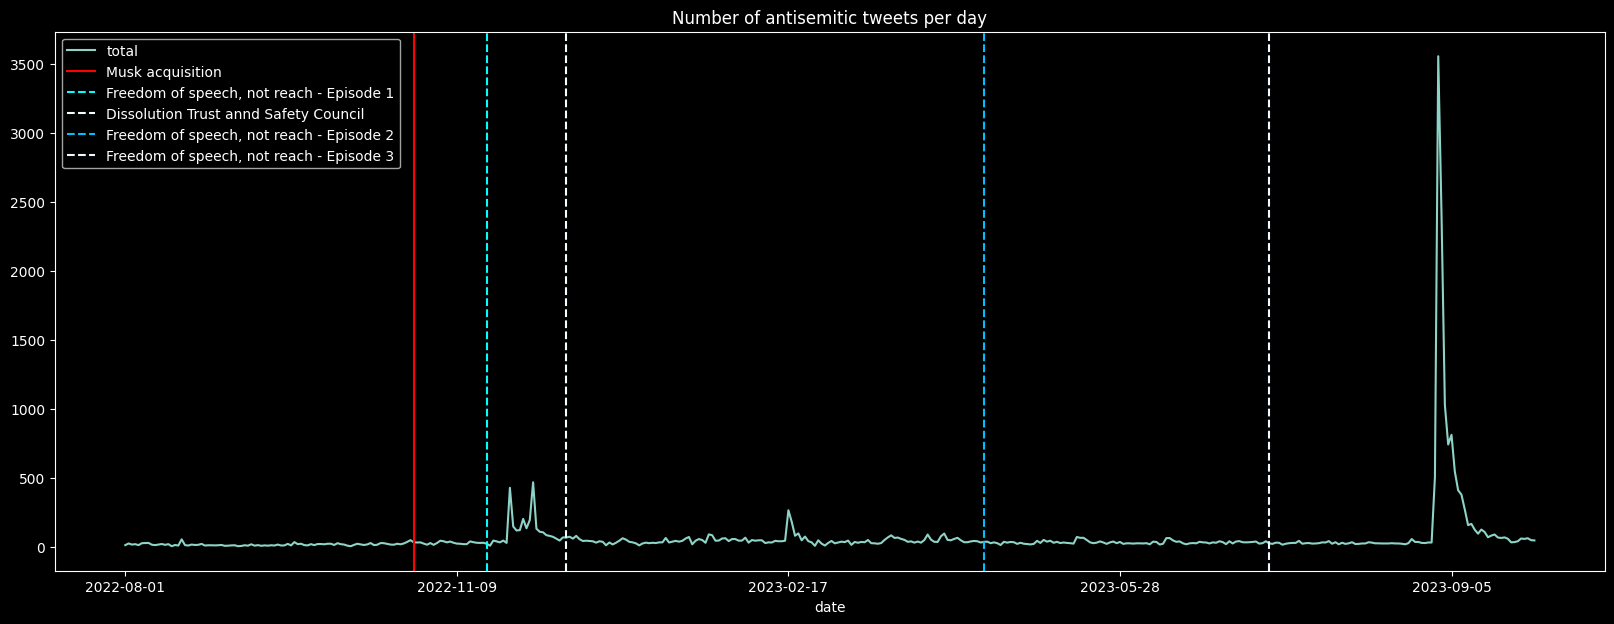

In [49]:
df = df_total_daily.set_index('date')
plt.style.use('dark_background')
ax = df.plot(stacked=True, figsize=(20,7))


po1, po2, po3, po4, po5  = position(df)
ax.axvline(po1, color=important_dates['2022-10-27']['color'], linestyle=important_dates['2022-10-27']['linestyle'], label=important_dates['2022-10-27']['label'])
ax.axvline(po2, color=important_dates['2022-11-18']['color'], linestyle=important_dates['2022-11-18']['linestyle'], label=important_dates['2022-11-18']['label'])
ax.axvline(po3, color=important_dates['2022-12-12']['color'], linestyle=important_dates['2022-12-12']['linestyle'], label=important_dates['2022-12-12']['label'])
ax.axvline(po4, color=important_dates['2023-04-17']['color'], linestyle=important_dates['2023-04-17']['linestyle'], label=important_dates['2023-04-17']['label'])
ax.axvline(po5, color=important_dates['2023-07-12']['color'], linestyle=important_dates['2023-07-12']['linestyle'], label=important_dates['2023-07-12']['label'])

plt.title("Number of antisemitic tweets per day")
plt.legend()

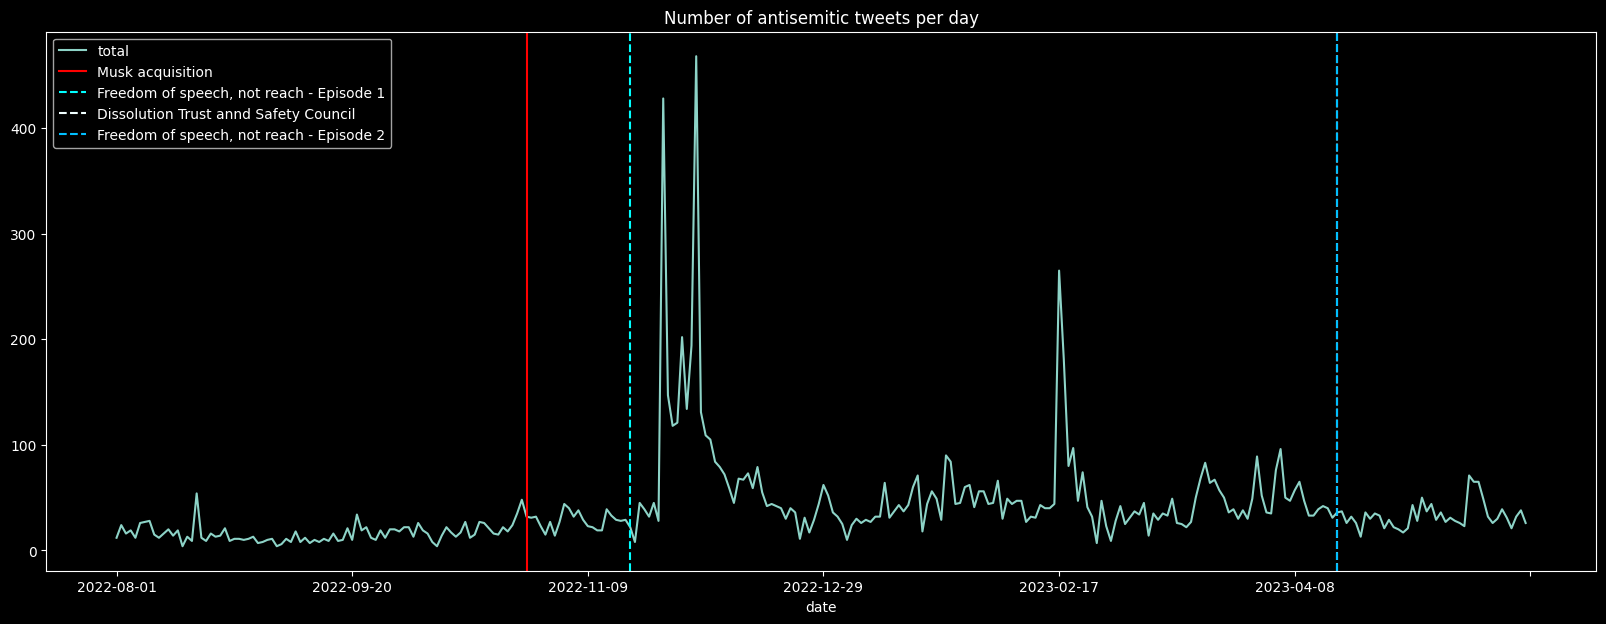

In [42]:
df = df_total_daily.set_index('date').head(300)
plt.style.use('dark_background')
ax = df.plot(stacked=True, figsize=(20,7))

po1 = list(df.index).index('2022-10-27')
po2 = list(df.index).index('2022-11-18')
po3 = list(df.index).index('2023-04-17')
po4 = list(df.index).index('2023-04-17')

ax.axvline(po1, color=important_dates['2022-10-27']['color'], linestyle=important_dates['2022-10-27']['linestyle'], label=important_dates['2022-10-27']['label'])
ax.axvline(po2, color=important_dates['2022-11-18']['color'], linestyle=important_dates['2022-11-18']['linestyle'], label=important_dates['2022-11-18']['label'])
ax.axvline(po3, color=important_dates['2022-12-12']['color'], linestyle=important_dates['2022-12-12']['linestyle'], label=important_dates['2022-12-12']['label'])
ax.axvline(po4, color=important_dates['2023-04-17']['color'], linestyle=important_dates['2023-04-17']['linestyle'], label=important_dates['2023-04-17']['label'])

plt.title("Number of antisemitic tweets per day")
plt.legend()

## Hashtags

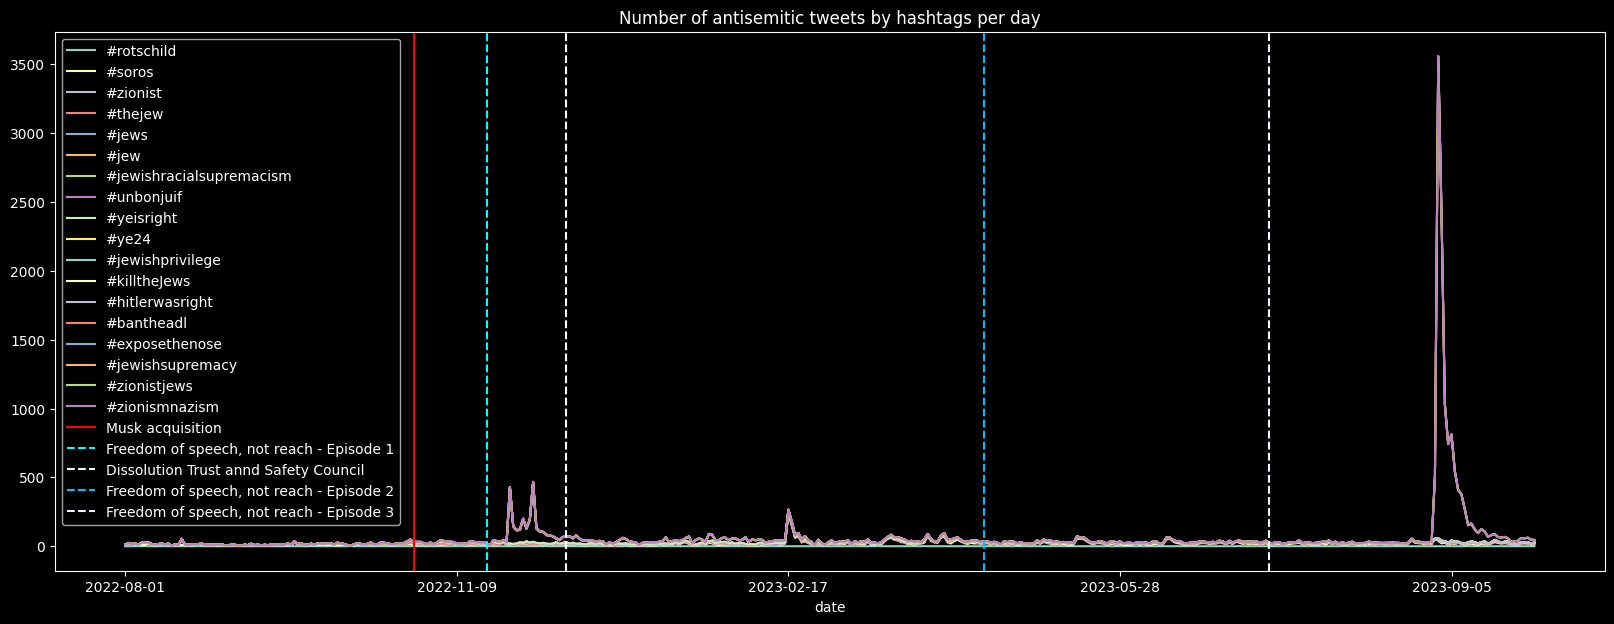

In [65]:
#ax = df_hash.plot.bar(rot=0)
df = df_hash_daily.set_index('date')
plt.style.use('dark_background')
ax = df.plot(stacked=True, figsize=(20,7))

po1, po2, po3, po4, po5  = position(df)
ax.axvline(po1, color=important_dates['2022-10-27']['color'], linestyle=important_dates['2022-10-27']['linestyle'], label=important_dates['2022-10-27']['label'])
ax.axvline(po2, color=important_dates['2022-11-18']['color'], linestyle=important_dates['2022-11-18']['linestyle'], label=important_dates['2022-11-18']['label'])
ax.axvline(po3, color=important_dates['2022-12-12']['color'], linestyle=important_dates['2022-12-12']['linestyle'], label=important_dates['2022-12-12']['label'])
ax.axvline(po4, color=important_dates['2023-04-17']['color'], linestyle=important_dates['2023-04-17']['linestyle'], label=important_dates['2023-04-17']['label'])
ax.axvline(po5, color=important_dates['2023-07-12']['color'], linestyle=important_dates['2023-07-12']['linestyle'], label=important_dates['2023-07-12']['label'])
plt.title("Number of antisemitic tweets by hashtags per day")
plt.legend()


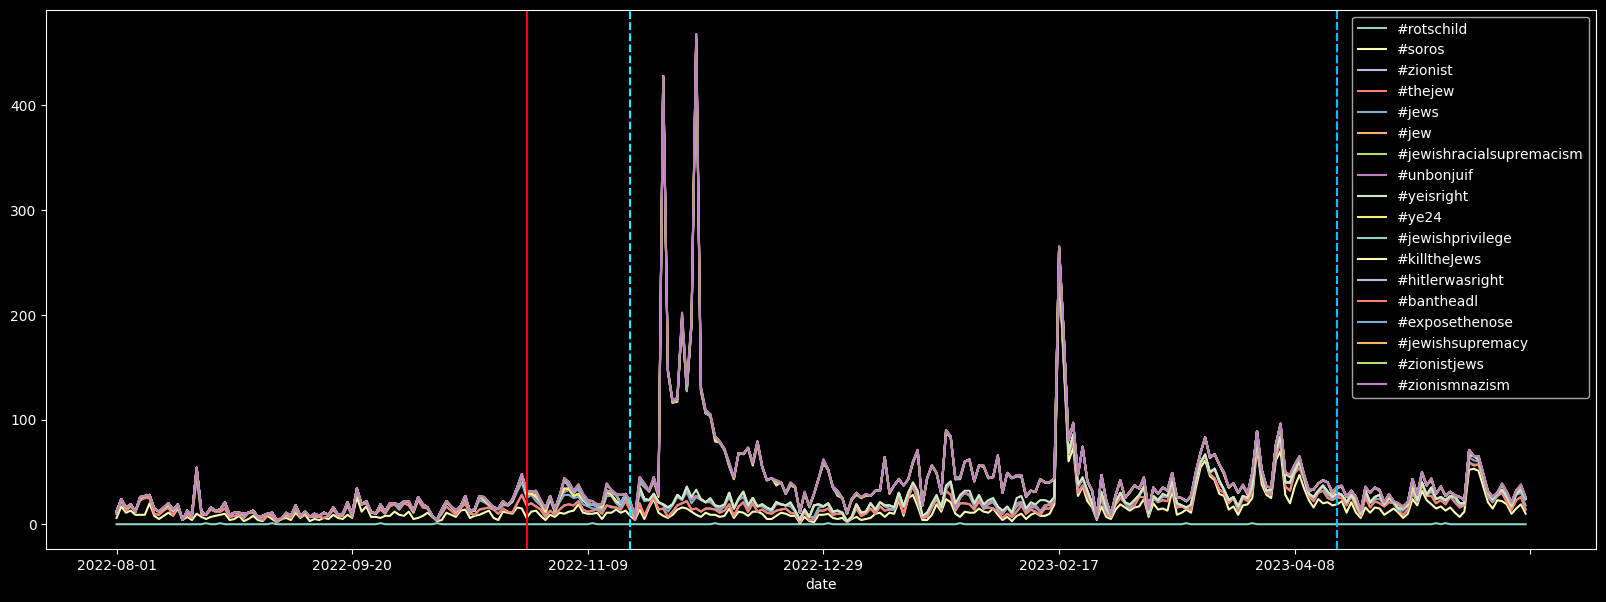

In [52]:
df = df_hash_daily.set_index('date').head(300)
plt.style.use('dark_background')
ax = df.plot(stacked=True, figsize=(20,7))

po1 = list(df.index).index('2022-10-27')
po2 = list(df.index).index('2022-11-18')
po3 = list(df.index).index('2023-04-17')
po4 = list(df.index).index('2023-04-17')

ax.axvline(po1, color=important_dates['2022-10-27']['color'], linestyle=important_dates['2022-10-27']['linestyle'], label=important_dates['2022-10-27']['label'])
ax.axvline(po2, color=important_dates['2022-11-18']['color'], linestyle=important_dates['2022-11-18']['linestyle'], label=important_dates['2022-11-18']['label'])
ax.axvline(po3, color=important_dates['2022-12-12']['color'], linestyle=important_dates['2022-12-12']['linestyle'], label=important_dates['2022-12-12']['label'])
ax.axvline(po4, color=important_dates['2023-04-17']['color'], linestyle=important_dates['2023-04-17']['linestyle'], label=important_dates['2023-04-17']['label'])


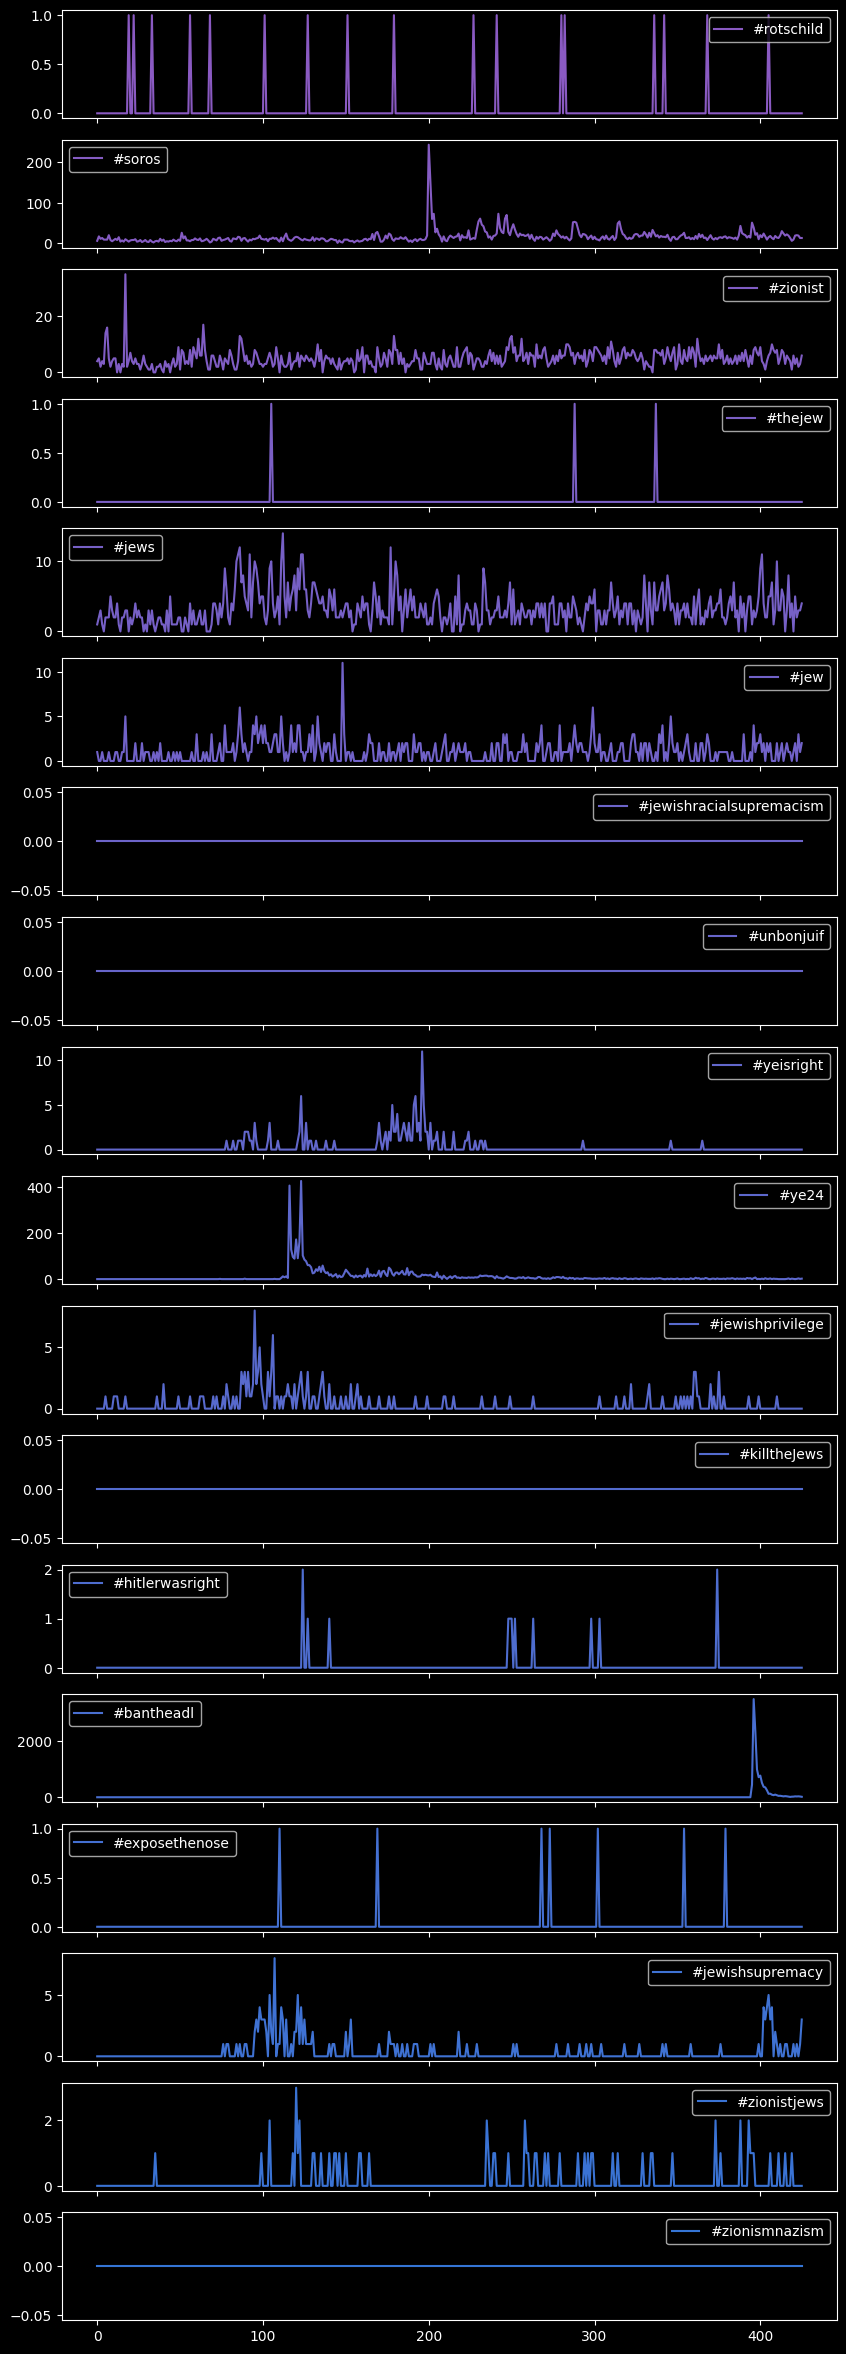

In [73]:
color1, color2 = "#8A5AC2", "#3575D5"
axes = df_hash_daily.plot(rot=0, subplots=True, figsize=(10,30), color=get_color_gradient(color1, color2, 18))
axes[1].legend(loc=2)

Text(0.5, 1.0, 'Number of antisemitic tweets hashtags per month')

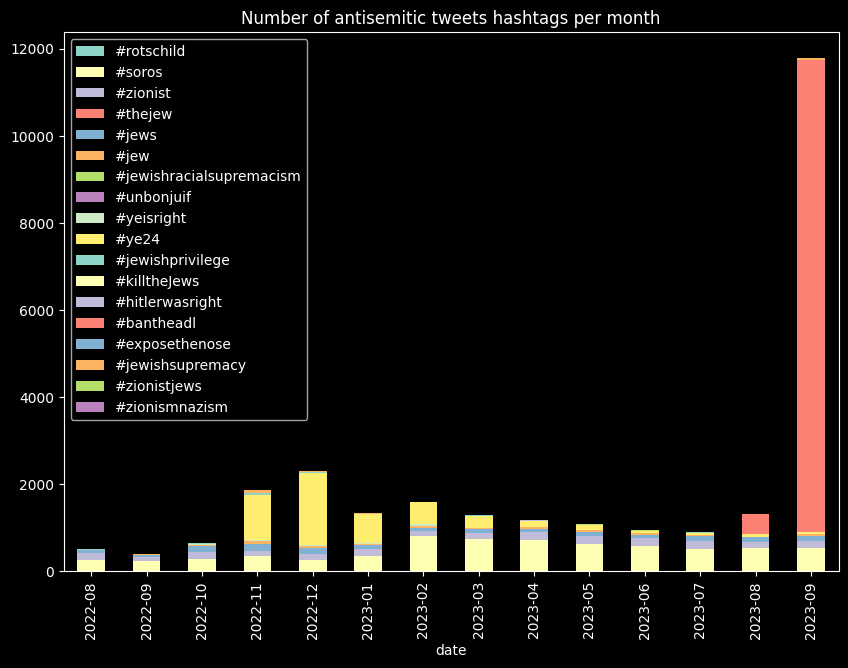

In [74]:
# Targeted Monthly
df = df_hash_monthly.set_index('date')
plt.style.use('dark_background')
color1 = "#8A5AC2"
color2 = "#3575D5"
ax = df.plot.bar(stacked=True, figsize=(10,7))
plt.title("Number of antisemitic tweets hashtags per month")

Text(0.5, 1.0, 'Number of antisemitic tweets hashtags per month')

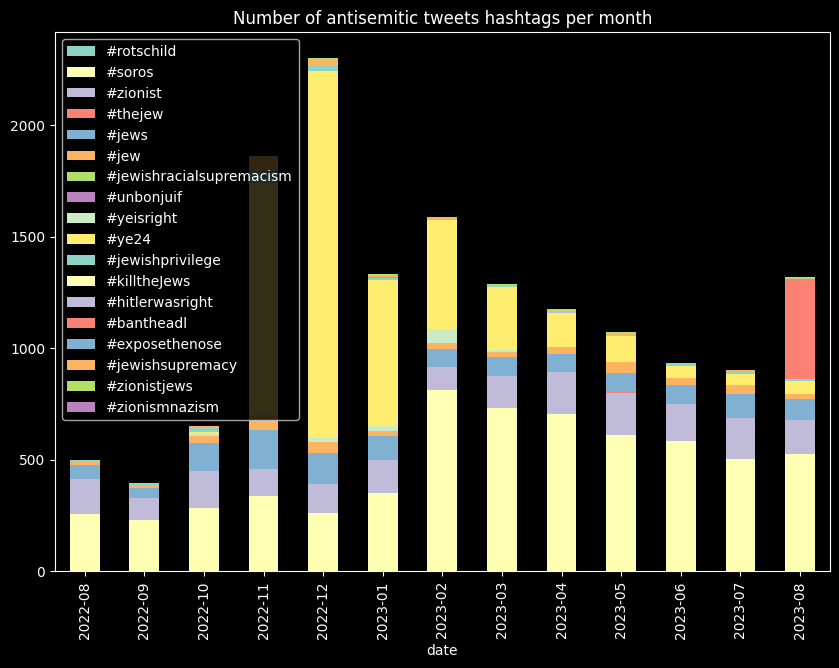

In [77]:
# Targeted Monthly
df = df_hash_monthly.set_index('date')
df = df[:-1]
plt.style.use('dark_background')
color1 = "#8A5AC2"
color2 = "#3575D5"
ax = df.plot.bar(stacked=True, figsize=(10,7))
plt.title("Number of antisemitic tweets hashtags per month")

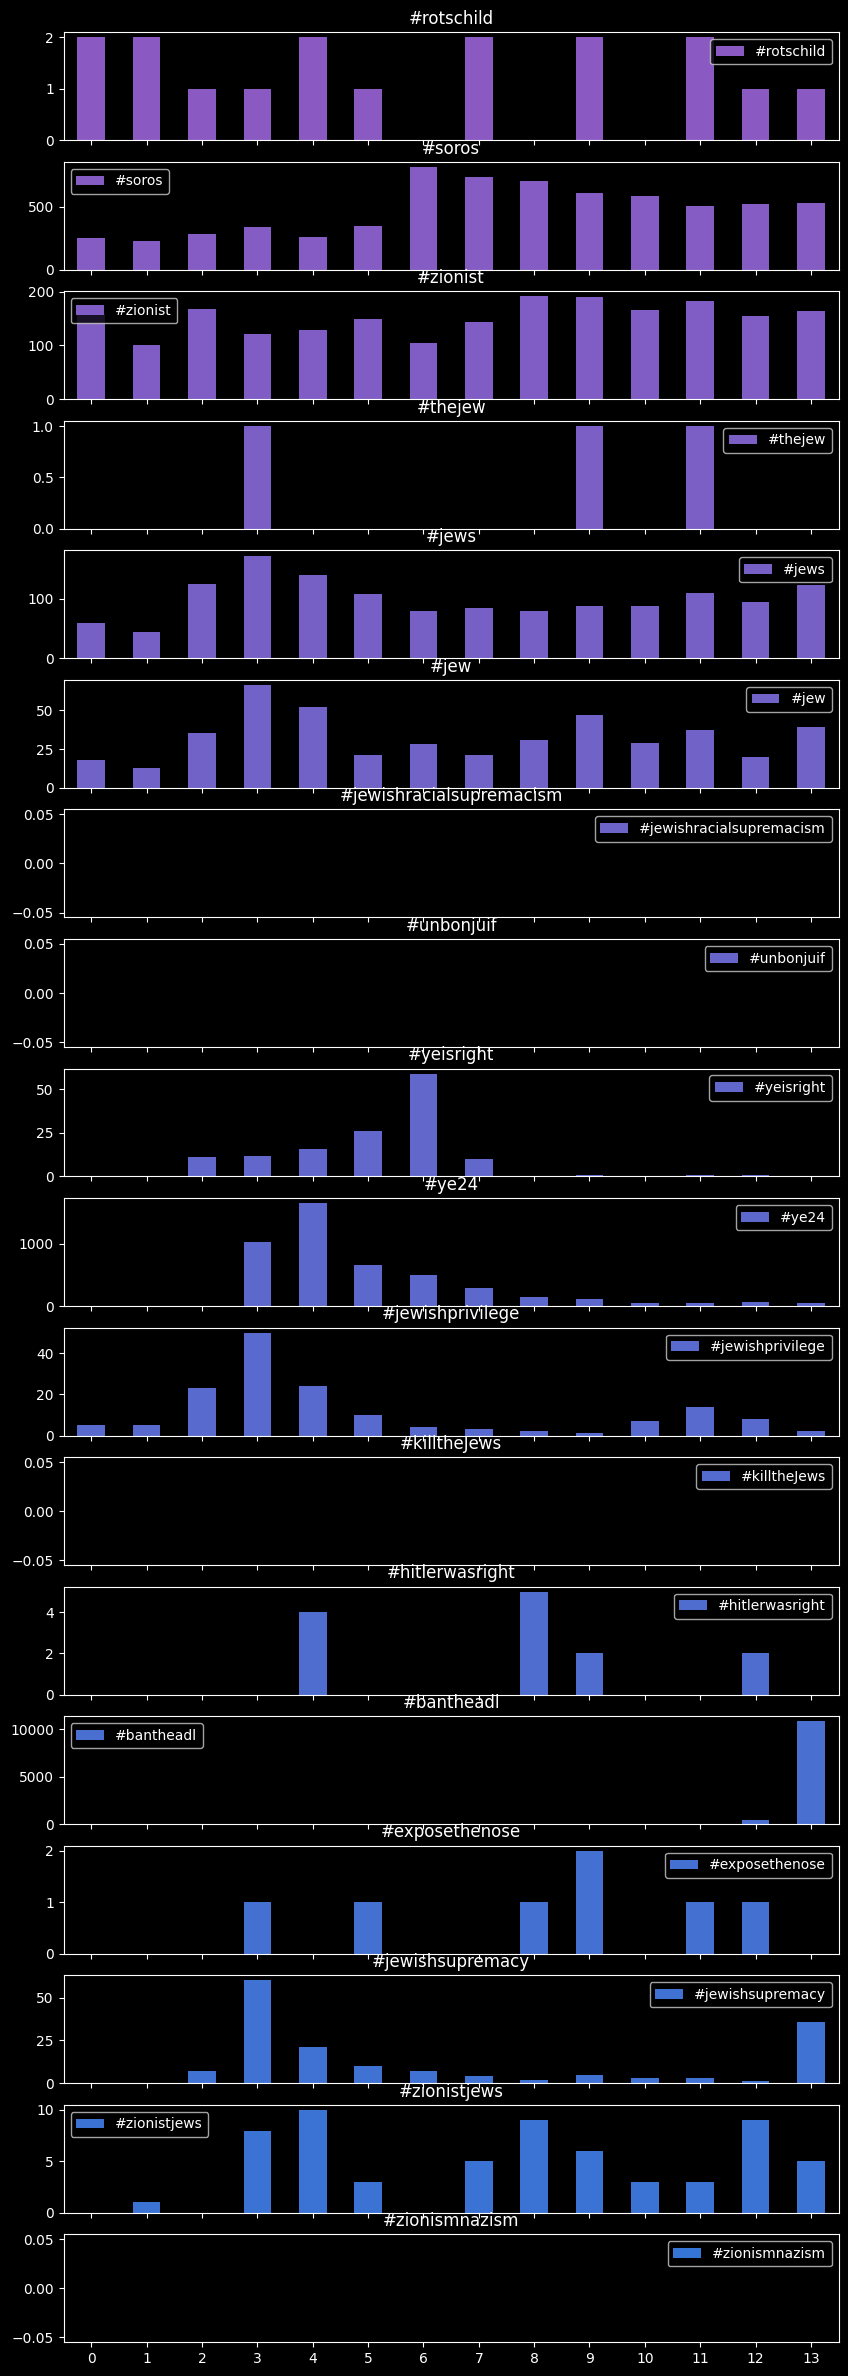

In [54]:
# Per hashtag per month
axes = df_hash_monthly.plot.bar(rot=0, subplots=True, figsize=(10,30), color=get_color_gradient(color1, color2, 18))
axes[1].legend(loc=2)

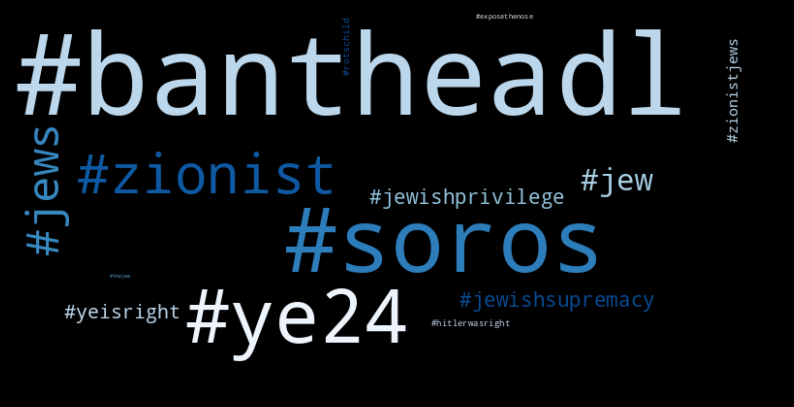

In [69]:
# Targeted hashtags importance

df = df_hash_monthly.drop(['date'], axis=1)
df = df.sum()
wordcloud = WordCloud(colormap="Blues",width=800, height=400)
wordcloud.generate_from_frequencies(frequencies=df)
plt.figure( figsize=(10,10) )
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

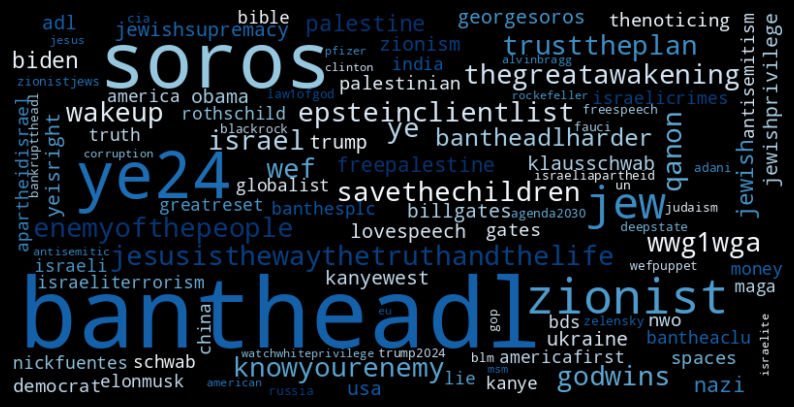

In [70]:
# All hashtags importance
big_text = ''
#clean
df = dataset[~dataset.hashtags.isna()]
all_hash = list(df.hashtags)
for text in all_hash:
  big_text += ' ' + text.replace("['",'').replace("']",'').replace(", '",'').replace("'",' ')
# Display
wordcloud = WordCloud(max_font_size=100, max_words=100, colormap="Blues", collocations=False, width=800, height=400).generate(big_text)
plt.figure( figsize=(10,10) )
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## User

<ipython-input-47-4973ad7d48ca>:118: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_user_sec = df.groupby('local_time', as_index=False).sum() #sum the number of tweets by merging by users
<ipython-input-47-4973ad7d48ca>:123: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_user_monthly = df_user_monthly.groupby('date', as_index=False).sum()


Text(0.5, 1.0, 'Activity of the top 10 most active users')

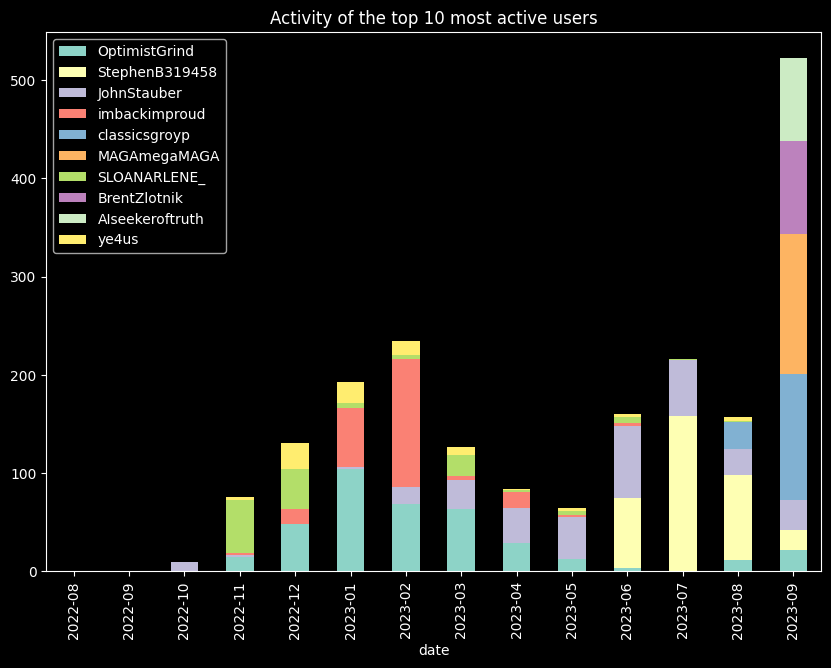

In [57]:
# Number of tweets by month by the most active user on the entire period
top = 10 #choose the number of most active users
plt.style.use('dark_background')
df_user_monthly = active_user_monthly(dataset, top)
df = df_user_monthly.set_index('date')
ax = df.plot.bar(stacked=True, figsize=(10,7))
plt.title(f"Activity of the top {top} most active users")

-------- BASIC INFORMATIONS ------------
==> Name: OptimistGrind, aka LOVE EVERYBODY
==> Description: Optimist Grind™️ Made in Detroit | Artist x Designer x Producer x Photographer x DJ | YE24 #LoveSpeech @KanyeWest
==> Location: Los Angeles, CA

==> Number of followers: 4390
==> Number of following: 1091
----------------------------------------


<ipython-input-47-4973ad7d48ca>:139: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_user_sec = df.groupby('local_time', as_index=False).sum()
<ipython-input-47-4973ad7d48ca>:144: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_user_daily =  df_user_daily.groupby('date', as_index=False).sum()
<ipython-input-47-4973ad7d48ca>:149: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_user_monthly = df_user_monthly.groupby('da

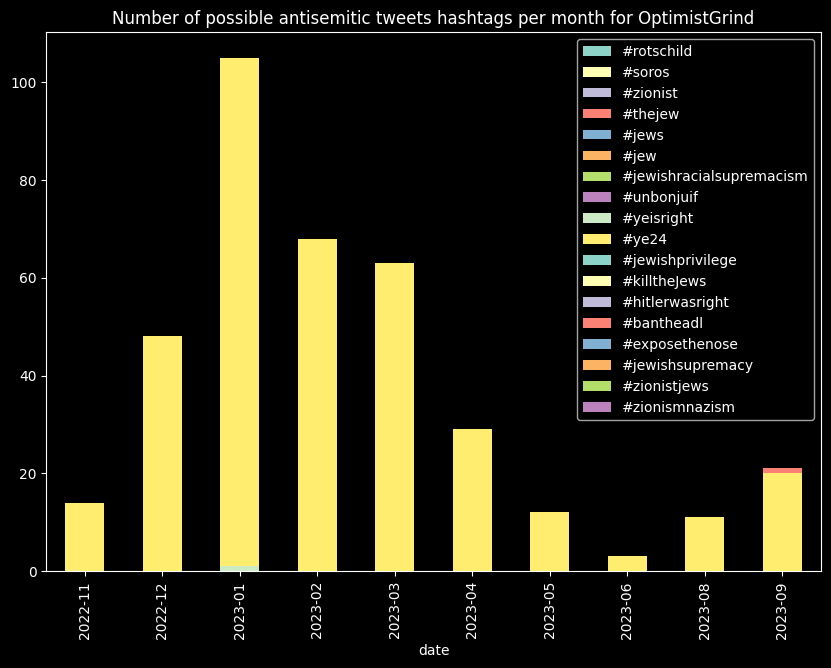

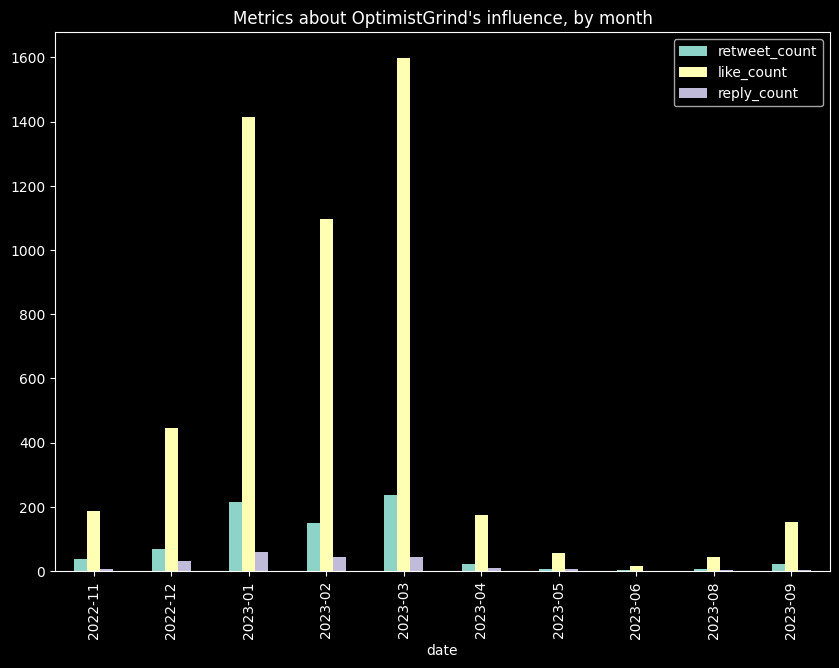

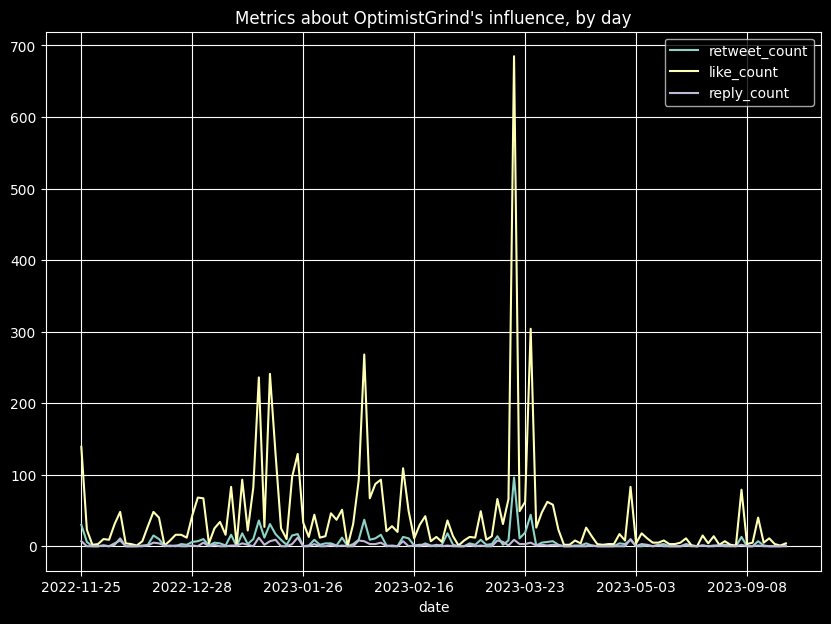

In [58]:
# Stats on specific users
name = 'OptimistGrind'

interest_col = ['local_time','url', 'timestamp_utc',
       'quoted_user', 'quoted_user_id', 'domains', 'hashtags', 'mentioned_ids',
       'mentioned_names', 'to_tweetid', 'to_username', 'to_userid', 'lang',
       'possibly_sensitive', 'retweet_count', 'like_count', 'reply_count',
       'user_screen_name', 'user_name', 'user_friends', 'user_followers',
       'user_location', 'user_verified', 'user_description', 'user_created_at',
       'user_id']

df_user = dataset[dataset['user_screen_name'] == name][interest_col]

basic_info(df_user, hashtag_list)

Influencer

In [59]:
# Users with that increase the most their influence

df = dataset[['user_screen_name', 'user_followers']].copy()
df2 = df.groupby('user_screen_name', as_index=False).min()
df2['max_followers'] = df.groupby('user_screen_name', as_index=False).max()['user_followers']
df2['variation_nb'] = df2['max_followers'] - df2['user_followers']
df2['variation_relative'] = round((df2['max_followers'] - df2['user_followers'])/(df2['max_followers'] + df2['user_followers'])*100,2)
df2 = df2.sort_values(by=['variation_nb'], ascending=[False])

df2.head(10)

,user_screen_name,user_followers,max_followers,variation_nb,variation_relative
4880,Muslimseye,25322.0,29746.0,4424.0,8.03
5264,Ostrov_A,243210.0,247484.0,4274.0,0.87
6201,SamParkerSenate,74661.0,77512.0,2851.0,1.87
3548,Jerusalem_Post,733720.0,736318.0,2598.0,0.18
9775,jakeshieldsajj,530898.0,532779.0,1881.0,0.18
3298,Israelkicksass,26266.0,27132.0,866.0,1.62
4289,Lucas_Gage_,192036.0,192778.0,742.0,0.19
541,AndyRogers07,4468.0,5093.0,625.0,6.54
8312,bambkb,101589.0,102200.0,611.0,0.30
2650,GaysForTrump24,8651.0,9217.0,566.0,3.17


-------- BASIC INFORMATIONS ------------
==> Name: Muslimseye, aka M o O n Y
==> Description: اَللّٰهُمَّ فَقِّهْنِا فِى الدِّيْنِ
==> Location: nan

==> Number of followers: 29746
==> Number of following: 126
----------------------------------------


<ipython-input-47-4973ad7d48ca>:139: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_user_sec = df.groupby('local_time', as_index=False).sum()
<ipython-input-47-4973ad7d48ca>:144: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_user_daily =  df_user_daily.groupby('date', as_index=False).sum()
<ipython-input-47-4973ad7d48ca>:149: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_user_monthly = df_user_monthly.groupby('da

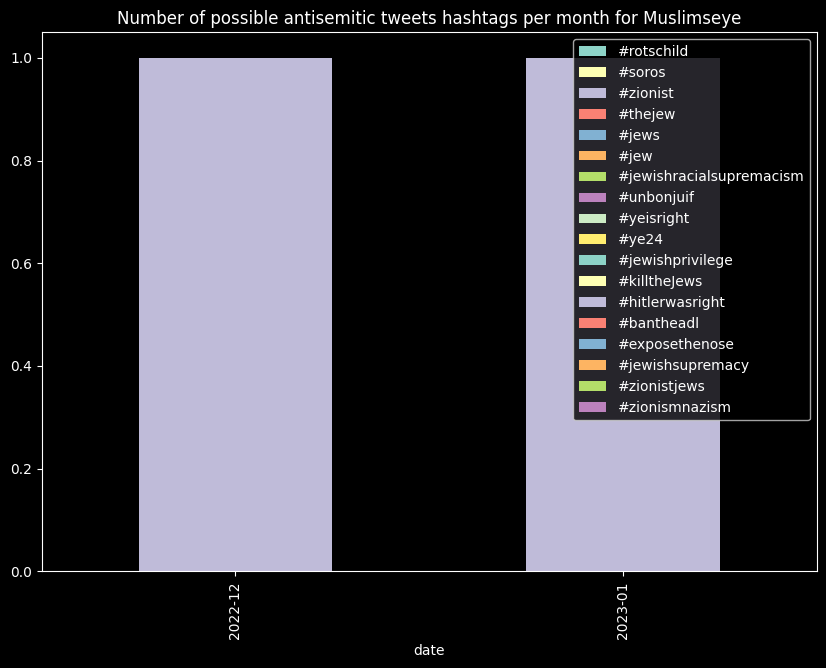

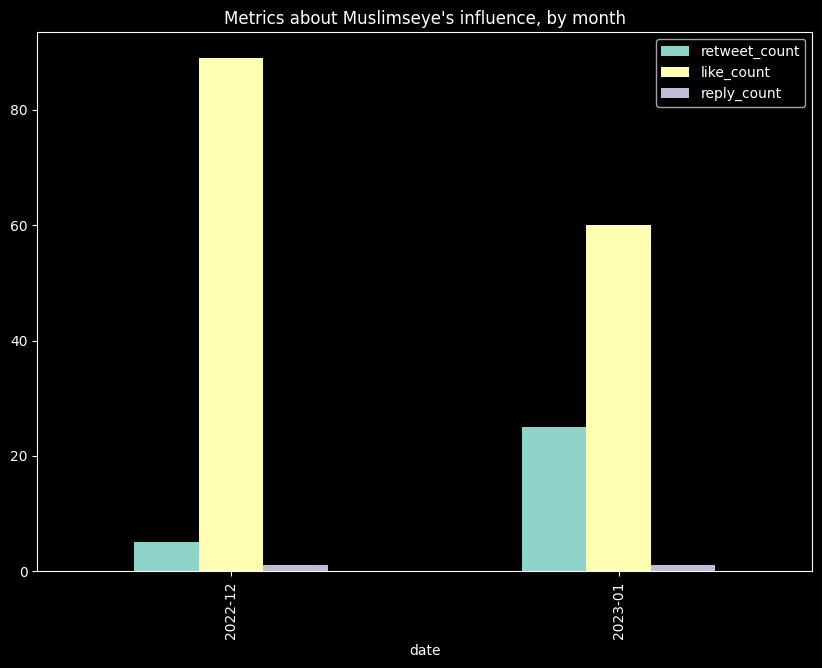

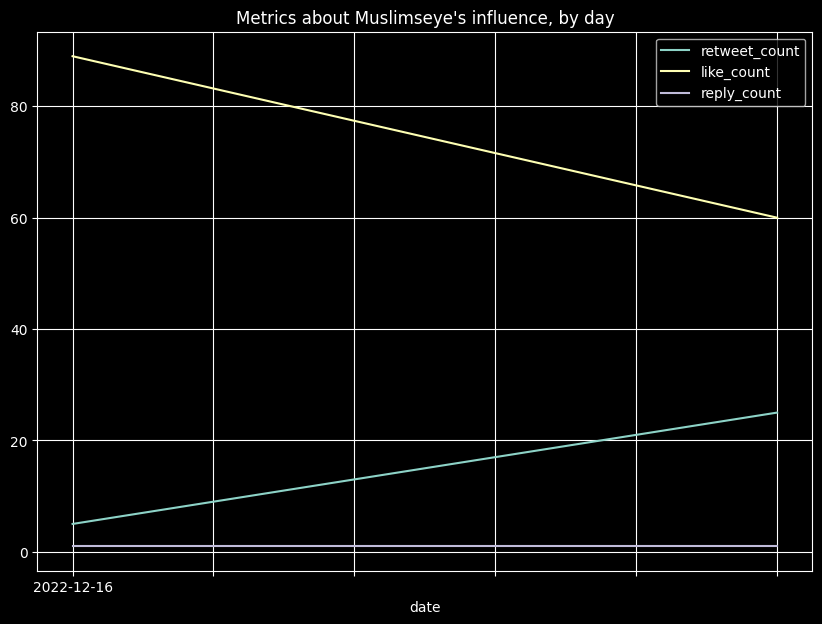

In [60]:
name = 'Muslimseye'

interest_col = ['local_time','url', 'timestamp_utc',
       'quoted_user', 'quoted_user_id', 'domains', 'hashtags', 'mentioned_ids',
       'mentioned_names', 'to_tweetid', 'to_username', 'to_userid', 'lang',
       'possibly_sensitive', 'retweet_count', 'like_count', 'reply_count',
       'user_screen_name', 'user_name', 'user_friends', 'user_followers',
       'user_location', 'user_verified', 'user_description', 'user_created_at',
       'user_id']

df_user = dataset[dataset['user_screen_name'] == name][interest_col]

basic_info(df_user, hashtag_list)

## Words

In [61]:
#Overall
test_tok = dataset.text.apply(tokenizeandstopwords)
big_text = ( " ".join(test_tok.values))

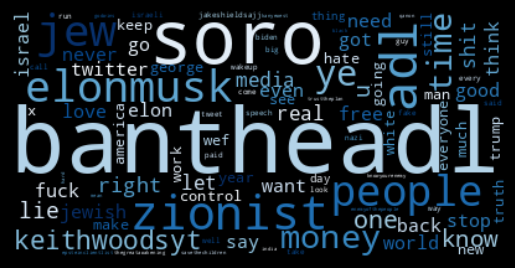

In [62]:
wordcloud = WordCloud(max_font_size=100, max_words=100, colormap="Blues", collocations=False).generate(big_text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

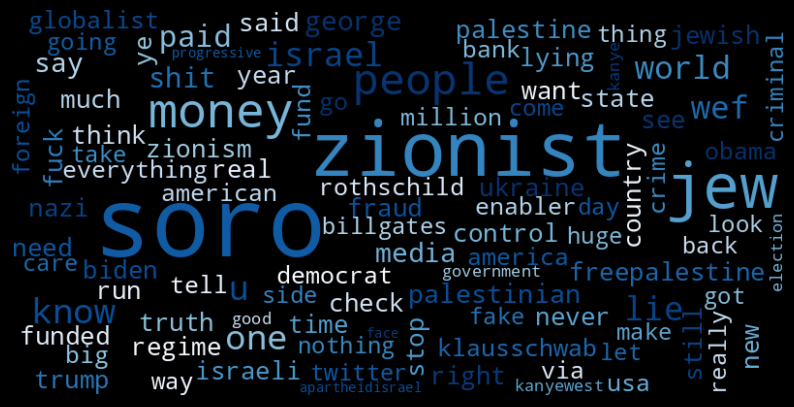

In [71]:
#Before Musk
test_tok = df_before.text.apply(tokenizeandstopwords)
big_text = (" ".join(test_tok.values))
wordcloud = WordCloud(max_font_size=100, max_words=100, colormap="Blues", collocations=False,width=800, height=400).generate(big_text)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

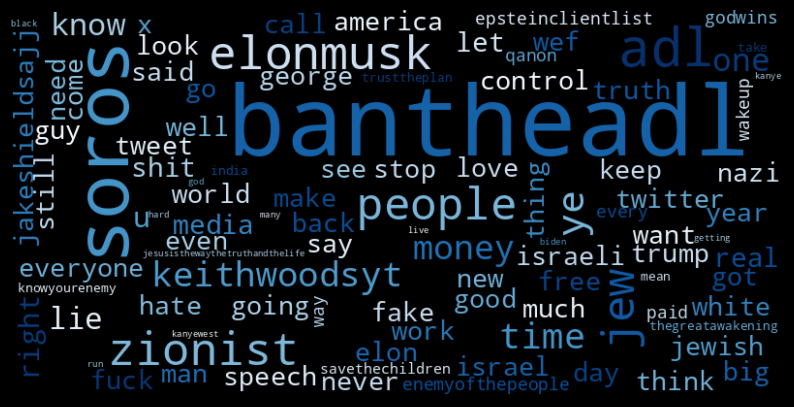

In [72]:
#After Musk
test_tok = df_after.text.apply(tokenizeandstopwords)
big_text = (" ".join(test_tok.values))
wordcloud = WordCloud(max_font_size=100, max_words=100, colormap="Blues", collocations=False,width=800, height=400).generate(big_text)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Regression

The main goal of this part is to quantify the influence of Musk acquisition on the amount of antisemitic tweets. The code below is just the preprocessing part, to build the correct dataset, which the regression (Event Study) will be performed in R [HERE]()

In [107]:
#Import data
%%capture
dataset = pd.read_csv(path)
dataset = dataset[dataset.timestamp_utc >= convert_date_time('2022-08-01')] # to have complete month, after august 2022
df_sec, df_daily, df_monthly = clean_reg(dataset)

In [108]:
df = to_reg(df_monthly, date='2022-10', n=1)
df = to_reg(df, date='2022-11', n=2)
df = to_reg(df, date='2022-12', n=3)
df = to_reg(df, date='2023-04', n=4)
df = to_reg(df, date='2023-07', n=5)

df.head()

,date,antisemitic,nb_tweet,date_1,time_to_treat_1,post_1,date_2,time_to_treat_2,post_2,date_3,time_to_treat_3,post_3,date_4,time_to_treat_4,post_4,date_5,time_to_treat_5,post_5
27,2023-09,1,11739,2022-10,11,1,2022-11,10,1,2022-12,9,1,2023-04,5,1,2023-07,2,1
25,2023-08,1,1317,2022-10,10,1,2022-11,9,1,2022-12,8,1,2023-04,4,1,2023-07,1,1
23,2023-07,1,891,2022-10,9,1,2022-11,8,1,2022-12,7,1,2023-04,3,1,2023-07,0,1
21,2023-06,1,929,2022-10,8,1,2022-11,7,1,2022-12,6,1,2023-04,2,1,2023-07,-1,0
19,2023-05,1,1065,2022-10,7,1,2022-11,6,1,2022-12,5,1,2023-04,1,1,2023-07,-3,0




*   ```date``` : interest month
*   ```antisemitic``` : 1 if it is antisemitic targeted tweet, 0 otherwise
*   ```nb_tweet``` : number of tweets during the interest month
*   ```date_musk``` : date of the acquisition of Twitter by Musk
*   ```time_to_treat``` : distance (in months) between data_musk annd the current_musk
*   ```post``` : 0 if the date is before date_musk, 0 otherwise



In [110]:
df.to_csv('//content/drive/Shareddrives/Group 3 - Sociology of Digital Public Spaces /Data/Data Analysis/Event_study.csv')